
wind_size = 60
stride_size = 5
b_size = 16
acuu- 71

<br>

wind_size = 60
stride_size = 10
b_size = 16
acuu- 70

<br>

wind_size = 120
stride_size = 10
b_size = 16
acuu- 74


wind_size = 150
stride_size = 10
b_size = 16
aucc - 72


wind_size = 180
stride_size = 10
b_size = 16
aucc - 24


wind_size = 120
stride_size = 20
b_size = 16
aucc - 30


wind_size = 120
stride_size = 5
b_size = 16
aucc - 70

# wind_size = 120, stride_size = 1, b_size = 16, learning rate=1e-4

In [2]:
# ✅ Fully improved model with patient-wise splitting and no shuffling across patients

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

# 📦 Load dataset

path = r"D:\Data\NYC\KINZ\KINECT_dataset_with_qor15.csv"

#path = "C:/Users/RAZER/Desktop/TEMp/New folder/KINECT_dataset_with_qor15.csv"


dataframe = pd.read_csv(path)
dataframe = dataframe[dataframe['walking_speed'] == 'Fast']
dataframe.dropna(subset=['QoR_class'], inplace=True)

# 📌 Graph structure
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
         ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
         ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
         ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
         ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
         ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
         ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
         ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
         ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
         ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'), ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')]

joint_to_idx = {j: i for i, j in enumerate(joints)}
edge_index = torch.tensor([[joint_to_idx[a], joint_to_idx[b]] for a, b in edges] + 
                          [[joint_to_idx[b], joint_to_idx[a]] for a, b in edges], dtype=torch.long).t()

# 🧱 Dataset
class WindowedSkeletonDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=30, stride=15):
        self.samples = []
        self.labels = []
        grouped = df.groupby(['patient_id', 'trial'])
        for _, group in grouped:
            group = group.sort_values('t_uniform')
            if len(group) < window_size:
                continue
            for i in range(0, len(group) - window_size + 1, stride):
                window = group.iloc[i:i+window_size]
                x_seq, aux_seq = [], []
                for _, row in window.iterrows():
                    node_features = [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['t_uniform']] for j in joints]
                    x_seq.append(torch.tensor(node_features, dtype=torch.float))
                    aux_seq.append(torch.tensor([row['left_foot_swing'], row['right_foot_swing'], row['pelvis_pos']], dtype=torch.float))
                label = torch.tensor(window['QoR_class'].mode().values[0], dtype=torch.float)
                self.samples.append((torch.stack(x_seq), torch.stack(aux_seq), label))
                self.labels.append(int(label.item()))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# 🔀 Patient-wise split
unique_ids = dataframe['patient_id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.3, random_state=42)

train_df = dataframe[dataframe['patient_id'].isin(train_ids)]
test_df  = dataframe[dataframe['patient_id'].isin(test_ids)]







#---------------------------------------------------------------------------------------------------------------------------------------------------------

wind_size = 120
stride_size = 10
b_size = 16

#---------------------------------------------------------------------------------------------------------------------------------------------------------






train_dataset = WindowedSkeletonDataset(train_df,window_size=wind_size, stride=stride_size)
test_dataset  = WindowedSkeletonDataset(test_df,window_size=wind_size, stride=stride_size)

# 📦 Dataloaders (no shuffle)
train_loader = DataLoader(train_dataset, batch_size=b_size)
test_loader  = DataLoader(test_dataset, batch_size=b_size)

# 🧠 Model
class WindowedSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.gcn = GCNConv(in_channels, hidden_channels)
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)
        self.aux_fc = nn.Linear(3, hidden_channels)
        self.classifier = nn.Linear(2 * hidden_channels, 1)

    def forward(self, x_seq, aux_seq):
        B, T, N, feat_dim = x_seq.shape
        x_seq = x_seq.view(B * T * N, feat_dim)
        full_edge_index = torch.cat([edge_index + b * N for b in range(B * T)], dim=1).to(x_seq.device)
        x = F.relu(self.gcn(x_seq, full_edge_index))
        x = x.view(B, T, N, -1).mean(2)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        aux = F.relu(self.aux_fc(aux_seq.mean(1)))
        return self.classifier(torch.cat([x, aux], dim=-1)).squeeze()

# ✅ Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WindowedSTGCN(in_channels=4, hidden_channels=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(1, 100):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x_seq, aux_seq, y in train_loader:
        x_seq, aux_seq, y = x_seq.to(device), aux_seq.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x_seq, aux_seq)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        correct += ((torch.sigmoid(out) >= 0.5).float() == y).sum().item()
        total += y.size(0)
    print(f"Epoch {epoch:03d} | Loss: {total_loss / total:.4f} | Accuracy: {correct / total:.4f}")

# 🧪 Final Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x_seq, aux_seq, y in test_loader:
        x_seq, aux_seq = x_seq.to(device), aux_seq.to(device)
        out = torch.sigmoid(model(x_seq, aux_seq))
        pred = (out >= 0.5).float()
        y_true.extend(y.cpu().numpy())
        y_pred.extend(pred.cpu().view(-1).numpy())


print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Good (0)", "Not Good (1)"]))

Epoch 001 | Loss: 31.9955 | Accuracy: 0.5153
Epoch 002 | Loss: 13.5788 | Accuracy: 0.4995
Epoch 003 | Loss: 12.5332 | Accuracy: 0.5000
Epoch 004 | Loss: 11.4555 | Accuracy: 0.4995
Epoch 005 | Loss: 10.4565 | Accuracy: 0.4832
Epoch 006 | Loss: 9.4694 | Accuracy: 0.4761
Epoch 007 | Loss: 8.3562 | Accuracy: 0.4720
Epoch 008 | Loss: 6.1783 | Accuracy: 0.5112
Epoch 009 | Loss: 4.3919 | Accuracy: 0.5183
Epoch 010 | Loss: 3.3671 | Accuracy: 0.5295
Epoch 011 | Loss: 2.9613 | Accuracy: 0.4939
Epoch 012 | Loss: 3.0335 | Accuracy: 0.5056
Epoch 013 | Loss: 2.8485 | Accuracy: 0.5173
Epoch 014 | Loss: 2.8219 | Accuracy: 0.5188
Epoch 015 | Loss: 2.8178 | Accuracy: 0.5178
Epoch 016 | Loss: 2.7999 | Accuracy: 0.5148
Epoch 017 | Loss: 2.7875 | Accuracy: 0.5153
Epoch 018 | Loss: 2.7742 | Accuracy: 0.5158
Epoch 019 | Loss: 2.7624 | Accuracy: 0.5163
Epoch 020 | Loss: 2.7525 | Accuracy: 0.5173
Epoch 021 | Loss: 2.7409 | Accuracy: 0.5183
Epoch 022 | Loss: 2.7348 | Accuracy: 0.5178
Epoch 023 | Loss: 2.7197 | 

In [7]:
from collections import defaultdict
import pandas as pd
import torch

model.eval()
patient_results = defaultdict(list)

# Align test_df index to help lookup patient IDs
test_df = test_df.reset_index(drop=True)

with torch.no_grad():
    for i in range(len(test_dataset)):
        x_seq, aux_seq, y = test_dataset[i]
        patient_id = test_df.iloc[i]['patient_id']
        x_seq, aux_seq = x_seq.unsqueeze(0).to(device), aux_seq.unsqueeze(0).to(device)
        output = model(x_seq, aux_seq)
        prob = torch.sigmoid(output).item()
        pred_label = int(prob >= 0.5)
        true_label = int(y.item())

        patient_results[patient_id].append({
            'pred': pred_label,
            'true': true_label,
            'prob': prob
        })

# Build summary per patient
summary = []
for pid, records in patient_results.items():
    preds = [r['pred'] for r in records]
    trues = [r['true'] for r in records]
    probs = [r['prob'] for r in records]

    correct_count = sum(p == t for p, t in zip(preds, trues))
    total = len(records)
    valid_percentage = 100 * correct_count / total
    invalid_percentage = 100 - valid_percentage

    summary.append({
        'PatientID': pid,
        'Predicted_QoR_class': max(set(preds), key=preds.count),
        'Actual_QoR_class': max(set(trues), key=trues.count),
        'valid_percentage': round(valid_percentage, 2),
        'invalid_percentage': round(invalid_percentage, 2),
        'average_model_output': round(sum(probs) / len(probs), 6)
    })

# Convert to DataFrame and view
report_df = pd.DataFrame(summary).sort_values(by='PatientID').reset_index(drop=True)
display(report_df)

# Save if needed
# report_df.to_csv("QoR_Per_Patient_Report.csv", index=False)


,PatientID,Predicted_QoR_class,Actual_QoR_class,valid_percentage,invalid_percentage,average_model_output
0,001-LO,0,0,68.3,31.7,0.061899


In [8]:
patient_id = test_df.iloc[i]['patient_id']
patient_id

'001-LO'

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split

# 📦 Load dataset
path = r"D:\Data\NYC\KINZ\KINECT_dataset_with_qor15.csv"
dataframe = pd.read_csv(path)
dataframe = dataframe[dataframe['walking_speed'] == 'Fast']
dataframe.dropna(subset=['QoR_class'], inplace=True)

# 📌 Graph structure
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
         ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
         ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
         ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
         ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
         ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
         ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
         ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
         ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
         ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'), ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')]

joint_to_idx = {j: i for i, j in enumerate(joints)}
edge_index = torch.tensor([[joint_to_idx[a], joint_to_idx[b]] for a, b in edges] +
                          [[joint_to_idx[b], joint_to_idx[a]] for a, b in edges], dtype=torch.long).t()

# 🧱 Dataset with patient ID tracking
class WindowedSkeletonDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=30, stride=15):
        self.samples = []
        grouped = df.groupby(['patient_id', 'trial'])
        for (patient_id, trial), group in grouped:
            group = group.sort_values('t_uniform')
            if len(group) < window_size:
                continue
            for i in range(0, len(group) - window_size + 1, stride):
                window = group.iloc[i:i+window_size]
                x_seq, aux_seq = [], []
                for _, row in window.iterrows():
                    node_features = [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['t_uniform']] for j in joints]
                    x_seq.append(torch.tensor(node_features, dtype=torch.float))
                    aux_seq.append(torch.tensor([row['left_foot_swing'], row['right_foot_swing'], row['pelvis_pos']], dtype=torch.float))
                label = torch.tensor(window['QoR_class'].mode().values[0], dtype=torch.float)
                self.samples.append({
                    'x_seq': torch.stack(x_seq),
                    'aux_seq': torch.stack(aux_seq),
                    'label': label,
                    'patient_id': patient_id
                })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        return sample['x_seq'], sample['aux_seq'], sample['label'], sample['patient_id']

# 🔀 Patient-wise split
unique_ids = dataframe['patient_id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.3, random_state=42)

train_df = dataframe[dataframe['patient_id'].isin(train_ids)]
test_df  = dataframe[dataframe['patient_id'].isin(test_ids)]

# Dataset creation
wind_size = 120
stride_size = 10
b_size = 16

train_dataset = WindowedSkeletonDataset(train_df, window_size=wind_size, stride=stride_size)
test_dataset  = WindowedSkeletonDataset(test_df, window_size=wind_size, stride=stride_size)

train_loader = DataLoader(train_dataset, batch_size=b_size)
test_loader  = DataLoader(test_dataset, batch_size=b_size)

# 🧠 Model
class WindowedSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.gcn = GCNConv(in_channels, hidden_channels)
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)
        self.aux_fc = nn.Linear(3, hidden_channels)
        self.classifier = nn.Linear(2 * hidden_channels, 1)

    def forward(self, x_seq, aux_seq):
        B, T, N, feat_dim = x_seq.shape
        x_seq = x_seq.view(B * T * N, feat_dim)
        full_edge_index = torch.cat([edge_index + b * N for b in range(B * T)], dim=1).to(x_seq.device)
        x = F.relu(self.gcn(x_seq, full_edge_index))
        x = x.view(B, T, N, -1).mean(2)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        aux = F.relu(self.aux_fc(aux_seq.mean(1)))
        return self.classifier(torch.cat([x, aux], dim=-1)).squeeze()

# ✅ Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WindowedSTGCN(in_channels=4, hidden_channels=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(1, 100):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x_seq, aux_seq, y, _ in train_loader:
        x_seq, aux_seq, y = x_seq.to(device), aux_seq.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x_seq, aux_seq)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        correct += ((torch.sigmoid(out) >= 0.5).float() == y).sum().item()
        total += y.size(0)
    print(f"Epoch {epoch:03d} | Loss: {total_loss / total:.4f} | Accuracy: {correct / total:.4f}")

# 🧪 Patient-wise Evaluation
model.eval()
patient_results = defaultdict(list)
with torch.no_grad():
    for i in range(len(test_dataset)):
        x_seq, aux_seq, y, patient_id = test_dataset[i]
        x_seq, aux_seq = x_seq.unsqueeze(0).to(device), aux_seq.unsqueeze(0).to(device)
        output = model(x_seq, aux_seq)
        prob = torch.sigmoid(output).item()
        pred_label = int(prob >= 0.5)
        true_label = int(y.item())

        patient_results[patient_id].append({
            'pred': pred_label,
            'true': true_label,
            'prob': prob
        })

# Build summary
summary = []
for pid, records in patient_results.items():
    preds = [r['pred'] for r in records]
    trues = [r['true'] for r in records]
    probs = [r['prob'] for r in records]

    correct_count = sum(p == t for p, t in zip(preds, trues))
    total = len(records)
    valid_percentage = 100 * correct_count / total
    invalid_percentage = 100 - valid_percentage

    summary.append({
        'PatientID': pid,
        'Predicted_QoR_class': max(set(preds), key=preds.count),
        'Actual_QoR_class': max(set(trues), key=trues.count),
        'valid_percentage': round(valid_percentage, 2),
        'invalid_percentage': round(invalid_percentage, 2),
        'average_model_output': round(sum(probs) / len(probs), 6)
    })

# Convert to DataFrame and display
report_df = pd.DataFrame(summary).sort_values(by='PatientID').reset_index(drop=True)
print(report_df)


Epoch 001 | Loss: 5.2177 | Accuracy: 0.5371
Epoch 002 | Loss: 3.3741 | Accuracy: 0.5498
Epoch 003 | Loss: 3.0358 | Accuracy: 0.5504
Epoch 004 | Loss: 2.8656 | Accuracy: 0.5514
Epoch 005 | Loss: 2.7052 | Accuracy: 0.5509
Epoch 006 | Loss: 2.3874 | Accuracy: 0.5519
Epoch 007 | Loss: 2.2883 | Accuracy: 0.5463
Epoch 008 | Loss: 2.2746 | Accuracy: 0.5422
Epoch 009 | Loss: 2.2652 | Accuracy: 0.5371
Epoch 010 | Loss: 2.2535 | Accuracy: 0.5376
Epoch 011 | Loss: 2.2468 | Accuracy: 0.5387
Epoch 012 | Loss: 2.2417 | Accuracy: 0.5366
Epoch 013 | Loss: 2.2334 | Accuracy: 0.5361
Epoch 014 | Loss: 2.2225 | Accuracy: 0.5341
Epoch 015 | Loss: 2.2103 | Accuracy: 0.5336
Epoch 016 | Loss: 2.1929 | Accuracy: 0.5326
Epoch 017 | Loss: 2.1692 | Accuracy: 0.5270
Epoch 018 | Loss: 2.1003 | Accuracy: 0.5153
Epoch 019 | Loss: 2.1372 | Accuracy: 0.5051
Epoch 020 | Loss: 2.1285 | Accuracy: 0.5025
Epoch 021 | Loss: 2.1198 | Accuracy: 0.4995
Epoch 022 | Loss: 2.1169 | Accuracy: 0.4980
Epoch 023 | Loss: 2.1142 | Accur

In [12]:
# ✅ Fully improved model with patient-wise splitting and no shuffling across patients

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

# 📦 Load dataset

path = r"D:\Data\NYC\KINZ\KINECT_dataset_with_qor15.csv"

dataframe = pd.read_csv(path)
dataframe = dataframe[dataframe['walking_speed'] == 'Fast']
dataframe.dropna(subset=['QoR_class'], inplace=True)

# 📌 Graph structure
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
         ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
         ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
         ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
         ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
         ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
         ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
         ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
         ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
         ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'), ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')]

joint_to_idx = {j: i for i, j in enumerate(joints)}
edge_index = torch.tensor([[joint_to_idx[a], joint_to_idx[b]] for a, b in edges] + 
                          [[joint_to_idx[b], joint_to_idx[a]] for a, b in edges], dtype=torch.long).t()

# 🧱 Dataset
class WindowedSkeletonDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=30, stride=15):
        self.samples = []
        self.labels = []
        grouped = df.groupby(['patient_id', 'trial'])
        for _, group in grouped:
            group = group.sort_values('t_uniform')
            if len(group) < window_size:
                continue
            for i in range(0, len(group) - window_size + 1, stride):
                window = group.iloc[i:i+window_size]
                x_seq, aux_seq = [], []
                for _, row in window.iterrows():
                    node_features = [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['t_uniform']] for j in joints]
                    x_seq.append(torch.tensor(node_features, dtype=torch.float))
                    aux_seq.append(torch.tensor([row['left_foot_swing'], row['right_foot_swing'], row['pelvis_pos']], dtype=torch.float))
                label = torch.tensor(window['QoR_class'].mode().values[0], dtype=torch.float)
                self.samples.append((torch.stack(x_seq), torch.stack(aux_seq), label))
                self.labels.append(int(label.item()))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# 🔀 Patient-wise split
unique_ids = dataframe['patient_id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.3, random_state=42)

train_df = dataframe[dataframe['patient_id'].isin(train_ids)]
test_df  = dataframe[dataframe['patient_id'].isin(test_ids)]

wind_size = 120
stride_size = 10
b_size = 16

train_dataset = WindowedSkeletonDataset(train_df, window_size=wind_size, stride=stride_size)
test_dataset  = WindowedSkeletonDataset(test_df, window_size=wind_size, stride=stride_size)

train_loader = DataLoader(train_dataset, batch_size=b_size)
test_loader  = DataLoader(test_dataset, batch_size=b_size)

# 🧠 Model
class WindowedSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.gcn = GCNConv(in_channels, hidden_channels)
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)
        self.aux_fc = nn.Linear(3, hidden_channels)
        self.classifier = nn.Linear(2 * hidden_channels, 1)

    def forward(self, x_seq, aux_seq):
        B, T, N, feat_dim = x_seq.shape
        x_seq = x_seq.view(B * T * N, feat_dim)
        full_edge_index = torch.cat([edge_index + b * N for b in range(B * T)], dim=1).to(x_seq.device)
        x = F.relu(self.gcn(x_seq, full_edge_index))
        x = x.view(B, T, N, -1).mean(2)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        aux = F.relu(self.aux_fc(aux_seq.mean(1)))
        return self.classifier(torch.cat([x, aux], dim=-1)).squeeze()

# ✅ Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WindowedSTGCN(in_channels=4, hidden_channels=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(1, 100):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x_seq, aux_seq, y in train_loader:
        x_seq, aux_seq, y = x_seq.to(device), aux_seq.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x_seq, aux_seq)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        correct += ((torch.sigmoid(out) >= 0.5).float() == y).sum().item()
        total += y.size(0)
    print(f"Epoch {epoch:03d} | Loss: {total_loss / total:.4f} | Accuracy: {correct / total:.4f}")

# 🧪 Final Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x_seq, aux_seq, y in test_loader:
        x_seq, aux_seq = x_seq.to(device), aux_seq.to(device)
        out = torch.sigmoid(model(x_seq, aux_seq))
        pred = (out >= 0.5).float()
        y_true.extend(y.cpu().numpy())
        y_pred.extend(pred.cpu().view(-1).numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Good (0)", "Not Good (1)"]))


Epoch 001 | Loss: 62.4791 | Accuracy: 0.4730
Epoch 002 | Loss: 3.4382 | Accuracy: 0.4817
Epoch 003 | Loss: 3.4234 | Accuracy: 0.4807
Epoch 004 | Loss: 3.3009 | Accuracy: 0.4852
Epoch 005 | Loss: 3.1941 | Accuracy: 0.4832
Epoch 006 | Loss: 3.0916 | Accuracy: 0.4852
Epoch 007 | Loss: 3.2550 | Accuracy: 0.4766
Epoch 008 | Loss: 3.0195 | Accuracy: 0.4975
Epoch 009 | Loss: 3.2109 | Accuracy: 0.4847
Epoch 010 | Loss: 2.9088 | Accuracy: 0.4964
Epoch 011 | Loss: 3.1530 | Accuracy: 0.5005
Epoch 012 | Loss: 2.8007 | Accuracy: 0.4852
Epoch 013 | Loss: 3.1228 | Accuracy: 0.5071
Epoch 014 | Loss: 2.7233 | Accuracy: 0.4822
Epoch 015 | Loss: 3.1006 | Accuracy: 0.5178
Epoch 016 | Loss: 2.6839 | Accuracy: 0.4771
Epoch 017 | Loss: 3.0782 | Accuracy: 0.5209
Epoch 018 | Loss: 2.6678 | Accuracy: 0.4746
Epoch 019 | Loss: 3.0577 | Accuracy: 0.5219
Epoch 020 | Loss: 2.6641 | Accuracy: 0.4791
Epoch 021 | Loss: 3.0399 | Accuracy: 0.5244
Epoch 022 | Loss: 2.6644 | Accuracy: 0.4817
Epoch 023 | Loss: 3.0277 | Accu

In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import classification_report
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Load dataset
path = r"D:\Data\NYC\KINZ\KINECT_dataset_with_qor15.csv"
dataframe = pd.read_csv(path)
dataframe = dataframe[dataframe['walking_speed'] == 'Fast']
dataframe.dropna(subset=['QoR_class'], inplace=True)

# Graph structure
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
         ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
         ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
         ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
         ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
         ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
         ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
         ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
         ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
         ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'), ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')]

joint_to_idx = {j: i for i, j in enumerate(joints)}
edge_index = torch.tensor([[joint_to_idx[a], joint_to_idx[b]] for a, b in edges] + 
                          [[joint_to_idx[b], joint_to_idx[a]] for a, b in edges], dtype=torch.long).t()

# Dataset
class WindowedSkeletonDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=120, stride=10):
        self.samples = []
        grouped = df.groupby(['patient_id', 'trial'])
        for (pid, trial), group in grouped:
            group = group.sort_values('t_uniform')
            if len(group) < window_size:
                continue
            for i in range(0, len(group) - window_size + 1, stride):
                window = group.iloc[i:i+window_size]
                x_seq, aux_seq = [], []
                for _, row in window.iterrows():
                    node_features = [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['t_uniform']] for j in joints]
                    x_seq.append(torch.tensor(node_features, dtype=torch.float))
                    aux_seq.append(torch.tensor([row['left_foot_swing'], row['right_foot_swing'], row['pelvis_pos']], dtype=torch.float))
                label = torch.tensor(window['QoR_class'].mode().values[0], dtype=torch.float)
                self.samples.append((torch.stack(x_seq), torch.stack(aux_seq), label, pid))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# Patient-wise split
unique_ids = dataframe['patient_id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.3, random_state=42)

train_df = dataframe[dataframe['patient_id'].isin(train_ids)]
test_df  = dataframe[dataframe['patient_id'].isin(test_ids)]

train_dataset = WindowedSkeletonDataset(train_df)
test_dataset  = WindowedSkeletonDataset(test_df)

# Model
class WindowedSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.gcn = GCNConv(in_channels, hidden_channels)
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)
        self.aux_fc = nn.Linear(3, hidden_channels)
        self.classifier = nn.Linear(2 * hidden_channels, 1)

    def forward(self, x_seq, aux_seq):
        B, T, N, feat_dim = x_seq.shape
        x_seq = x_seq.view(B * T * N, feat_dim)
        full_edge_index = torch.cat([edge_index + b * N for b in range(B * T)], dim=1).to(x_seq.device)
        x = F.relu(self.gcn(x_seq, full_edge_index))
        x = x.view(B, T, N, -1).mean(2)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        aux = F.relu(self.aux_fc(aux_seq.mean(1)))
        return self.classifier(torch.cat([x, aux], dim=-1)).view(-1)  # <-- ensure shape [B]

# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WindowedSTGCN(in_channels=4, hidden_channels=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(1, 101):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x_seq, aux_seq, y, _ in train_dataset:
        x_seq, aux_seq, y = x_seq.unsqueeze(0).to(device), aux_seq.unsqueeze(0).to(device), y.unsqueeze(0).to(device)
        optimizer.zero_grad()
        out = model(x_seq, aux_seq)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((torch.sigmoid(out) >= 0.5).float() == y).sum().item()
        total += 1
    print(f"Epoch {epoch:03d} | Loss: {total_loss / total:.4f} | Accuracy: {correct / total:.4f}")

# Evaluation - Patient-wise report
model.eval()
patient_results = defaultdict(list)

with torch.no_grad():
    for x_seq, aux_seq, y, pid in test_dataset:
        x_seq, aux_seq = x_seq.unsqueeze(0).to(device), aux_seq.unsqueeze(0).to(device)
        output = model(x_seq, aux_seq)
        prob = torch.sigmoid(output).item()
        pred_label = int(prob >= 0.5)
        true_label = int(y.item())

        patient_results[pid].append({
            'pred': pred_label,
            'true': true_label,
            'prob': prob
        })

# Summarize per patient
summary = []
for pid, records in patient_results.items():
    preds = [r['pred'] for r in records]
    trues = [r['true'] for r in records]
    probs = [r['prob'] for r in records]

    correct_count = sum(p == t for p, t in zip(preds, trues))
    total = len(records)
    valid_percentage = 100 * correct_count / total
    invalid_percentage = 100 - valid_percentage

    summary.append({
        'PatientID': pid,
        'Predicted_QoR_class': max(set(preds), key=preds.count),
        'Actual_QoR_class': max(set(trues), key=trues.count),
        'valid_percentage': round(valid_percentage, 2),
        'invalid_percentage': round(invalid_percentage, 2),
        'average_model_output': round(sum(probs) / len(probs), 6)
    })

# Display
report_df = pd.DataFrame(summary).sort_values(by='PatientID').reset_index(drop=True)
print(report_df)



Epoch 001 | Loss: 14.7414 | Accuracy: 0.7248
Epoch 002 | Loss: 14.6504 | Accuracy: 0.7309
Epoch 003 | Loss: 13.6332 | Accuracy: 0.7309
Epoch 004 | Loss: 13.6377 | Accuracy: 0.7284
Epoch 005 | Loss: 12.9257 | Accuracy: 0.7304
Epoch 006 | Loss: 12.5999 | Accuracy: 0.7325
Epoch 007 | Loss: 12.3075 | Accuracy: 0.7335
Epoch 008 | Loss: 12.2647 | Accuracy: 0.7299
Epoch 009 | Loss: 11.9928 | Accuracy: 0.7304
Epoch 010 | Loss: 11.7584 | Accuracy: 0.7304
Epoch 011 | Loss: 11.5194 | Accuracy: 0.7309
Epoch 012 | Loss: 11.5057 | Accuracy: 0.7330
Epoch 013 | Loss: 10.9004 | Accuracy: 0.7370
Epoch 014 | Loss: 10.6310 | Accuracy: 0.7391
Epoch 015 | Loss: 10.5328 | Accuracy: 0.7380
Epoch 016 | Loss: 10.4476 | Accuracy: 0.7375
Epoch 017 | Loss: 10.1943 | Accuracy: 0.7370
Epoch 018 | Loss: 9.9294 | Accuracy: 0.7370
Epoch 019 | Loss: 9.8819 | Accuracy: 0.7350
Epoch 020 | Loss: 9.6589 | Accuracy: 0.7350
Epoch 021 | Loss: 9.4688 | Accuracy: 0.7350
Epoch 022 | Loss: 9.3423 | Accuracy: 0.7340
Epoch 023 | Los

In [7]:
path = "C:/Users/RAZER/Desktop/TEMp/New folder/KINECT_dataset_with_qor15.csv"

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report, brier_score_loss
from sklearn.model_selection import train_test_split
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Dataset Path


# Load and preprocess dataset
dataframe = pd.read_csv(path)
dataframe = dataframe[dataframe['walking_speed'] == 'Fast']
dataframe.dropna(subset=['QoR_class'], inplace=True)

# Graph structure
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [(a, b) for a, b in zip(joints[:-1], joints[1:])]  # Simplified for this demo
joint_to_idx = {j: i for i, j in enumerate(joints)}
edge_index = torch.tensor([[joint_to_idx[a], joint_to_idx[b]] for a, b in edges] + 
                          [[joint_to_idx[b], joint_to_idx[a]] for a, b in edges], dtype=torch.long).t()

# Dataset class with patient-aware sequences
class WindowedSkeletonDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=30, stride=15):
        self.samples = []
        grouped = df.groupby(['patient_id', 'trial'])
        for (pid, trial), group in grouped:
            group = group.sort_values('t_uniform')
            if len(group) < window_size:
                continue
            for i in range(0, len(group) - window_size + 1, stride):
                window = group.iloc[i:i+window_size]
                x_seq, aux_seq = [], []
                for _, row in window.iterrows():
                    node_features = [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['t_uniform']] for j in joints]
                    x_seq.append(torch.tensor(node_features, dtype=torch.float))
                    aux_seq.append(torch.tensor([row['left_foot_swing'], row['right_foot_swing'], row['pelvis_pos']], dtype=torch.float))
                label = torch.tensor(window['QoR_class'].mode().values[0], dtype=torch.float)
                self.samples.append((torch.stack(x_seq), torch.stack(aux_seq), label, pid))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# Split patients (no overlap)
unique_ids = dataframe['patient_id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.3, random_state=42)
train_df = dataframe[dataframe['patient_id'].isin(train_ids)]
test_df = dataframe[dataframe['patient_id'].isin(test_ids)]

# Dataset creation
train_dataset = WindowedSkeletonDataset(train_df, window_size=120, stride=10)
test_dataset = WindowedSkeletonDataset(test_df, window_size=120, stride=10)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Model
class WindowedSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.gcn = GCNConv(in_channels, hidden_channels)
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)
        self.aux_fc = nn.Linear(3, hidden_channels)
        self.classifier = nn.Linear(2 * hidden_channels, 1)

    def forward(self, x_seq, aux_seq):
        B, T, N, feat_dim = x_seq.shape
        x_seq = x_seq.view(B * T * N, feat_dim)
        full_edge_index = torch.cat([edge_index + b * N for b in range(B * T)], dim=1).to(x_seq.device)
        x = F.relu(self.gcn(x_seq, full_edge_index))
        x = x.view(B, T, N, -1).mean(2)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        aux = F.relu(self.aux_fc(aux_seq.mean(1)))
        return self.classifier(torch.cat([x, aux], dim=-1)).squeeze()

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        if self.reduction == 'mean':
            return F_loss.mean()
        else:
            return F_loss.sum()

# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WindowedSTGCN(in_channels=4, hidden_channels=128).to(device)
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(1, 101):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x_seq, aux_seq, y, _ in train_dataset:
        x_seq, aux_seq, y = x_seq.unsqueeze(0).to(device), aux_seq.unsqueeze(0).to(device), y.unsqueeze(0).to(device)
        optimizer.zero_grad()
        out = model(x_seq, aux_seq)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((torch.sigmoid(out) >= 0.5).float() == y).sum().item()
        total += 1
    print(f"Epoch {epoch:03d} | Loss: {total_loss / total:.4f} | Accuracy: {correct / total:.4f}")

# Evaluation & Calibration
model.eval()
all_probs, all_labels = [], []
with torch.no_grad():
    for x_seq, aux_seq, y, pid in test_dataset:
        x_seq, aux_seq = x_seq.unsqueeze(0).to(device), aux_seq.unsqueeze(0).to(device)
        out = torch.sigmoid(model(x_seq, aux_seq)).cpu().numpy()
        all_probs.append(out[0])
        all_labels.append(y.item())

# Calibration Curve
prob_true, prob_pred = calibration_curve(all_labels, all_probs, n_bins=10)
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()


Epoch 001 | Loss: 25.7527 | Accuracy: 0.7131
Epoch 002 | Loss: 15.2850 | Accuracy: 0.7223
Epoch 003 | Loss: 14.7569 | Accuracy: 0.7253
Epoch 004 | Loss: 14.6506 | Accuracy: 0.7253
Epoch 005 | Loss: 14.1765 | Accuracy: 0.7279
Epoch 006 | Loss: 13.8433 | Accuracy: 0.7274
Epoch 007 | Loss: 13.6556 | Accuracy: 0.7304
Epoch 008 | Loss: 13.4036 | Accuracy: 0.7309
Epoch 009 | Loss: 13.6632 | Accuracy: 0.7253
Epoch 010 | Loss: 13.2580 | Accuracy: 0.7248
Epoch 011 | Loss: 12.8210 | Accuracy: 0.7299
Epoch 012 | Loss: 12.5108 | Accuracy: 0.7269
Epoch 013 | Loss: 12.0079 | Accuracy: 0.7314
Epoch 014 | Loss: 12.3900 | Accuracy: 0.7258
Epoch 015 | Loss: 11.1493 | Accuracy: 0.7340
Epoch 016 | Loss: 11.3130 | Accuracy: 0.7360
Epoch 017 | Loss: 11.0249 | Accuracy: 0.7365
Epoch 018 | Loss: 10.2009 | Accuracy: 0.7396
Epoch 019 | Loss: 10.5890 | Accuracy: 0.7340
Epoch 020 | Loss: 10.3546 | Accuracy: 0.7330
Epoch 021 | Loss: 9.9948 | Accuracy: 0.7319
Epoch 022 | Loss: 9.6746 | Accuracy: 0.7370
Epoch 023 | 

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

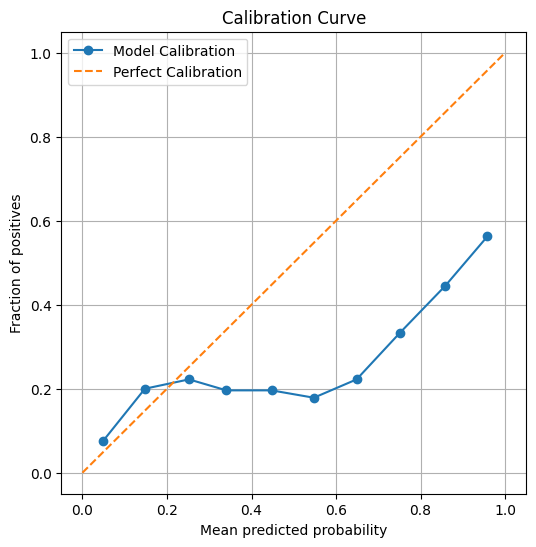

In [5]:
# Evaluation & Calibration
model.eval()
all_probs, all_labels = [], []
with torch.no_grad():
    for x_seq, aux_seq, y, pid in test_dataset:
        x_seq, aux_seq = x_seq.unsqueeze(0).to(device), aux_seq.unsqueeze(0).to(device)
        out = torch.sigmoid(model(x_seq, aux_seq)).cpu().item()
        all_probs.append(out)
        all_labels.append(y.item())

# Calibration Curve
prob_true, prob_pred = calibration_curve(all_labels, all_probs, n_bins=10)
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Evaluation - Patient-wise report
model.eval()
patient_results = defaultdict(list)

with torch.no_grad():
    for x_seq, aux_seq, y, pid in test_dataset:
        x_seq, aux_seq = x_seq.unsqueeze(0).to(device), aux_seq.unsqueeze(0).to(device)
        output = model(x_seq, aux_seq)
        prob = torch.sigmoid(output).item()
        pred_label = int(prob >= 0.5)
        true_label = int(y.item())

        patient_results[pid].append({
            'pred': pred_label,
            'true': true_label,
            'prob': prob
        })

# Summarize per patient
summary = []
for pid, records in patient_results.items():
    preds = [r['pred'] for r in records]
    trues = [r['true'] for r in records]
    probs = [r['prob'] for r in records]

    correct_count = sum(p == t for p, t in zip(preds, trues))
    total = len(records)
    valid_percentage = 100 * correct_count / total
    invalid_percentage = 100 - valid_percentage

    summary.append({
        'PatientID': pid,
        'Predicted_QoR_class': max(set(preds), key=preds.count),
        'Actual_QoR_class': max(set(trues), key=trues.count),
        'valid_percentage': round(valid_percentage, 2),
        'invalid_percentage': round(invalid_percentage, 2),
        'average_model_output': round(sum(probs) / len(probs), 6)
    })

# Display
report_df = pd.DataFrame(summary).sort_values(by='PatientID').reset_index(drop=True)
print(report_df)


   PatientID  Predicted_QoR_class  Actual_QoR_class  valid_percentage  \
0     001-LO                    1                 1             87.76   
1     005-GP                    1                 0              0.00   
2     006-TR                    0                 1              0.00   
3     010-RA                    0                 0             52.94   
4     011-CB                    1                 0              0.00   
5     013-MS                    1                 1             89.47   
6     018-OS                    1                 0              0.00   
7     020-MM                    1                 0             33.33   
8     025-PS                    1                 1             57.14   
9     033-JF                    1                 1            100.00   
10    037-MA                    1                 0             46.25   
11    039-EB                    0                 0             58.82   
12    040-KR                    1                 1

Epoch 001 | Loss: 20.6584 | Accuracy: 0.7340
Epoch 002 | Loss: 14.7264 | Accuracy: 0.7325
Epoch 003 | Loss: 14.8699 | Accuracy: 0.7269
Epoch 004 | Loss: 14.3328 | Accuracy: 0.7218
Epoch 005 | Loss: 13.4812 | Accuracy: 0.7248
Epoch 006 | Loss: 13.2029 | Accuracy: 0.7269
Epoch 007 | Loss: 12.7530 | Accuracy: 0.7299
Epoch 008 | Loss: 12.2863 | Accuracy: 0.7330
Epoch 009 | Loss: 12.0737 | Accuracy: 0.7340
Epoch 010 | Loss: 12.2825 | Accuracy: 0.7274
Epoch 011 | Loss: 12.1289 | Accuracy: 0.7263
Epoch 012 | Loss: 11.4230 | Accuracy: 0.7258
Epoch 013 | Loss: 11.2102 | Accuracy: 0.7289
Epoch 014 | Loss: 10.9512 | Accuracy: 0.7294
Epoch 015 | Loss: 10.6552 | Accuracy: 0.7294
Epoch 016 | Loss: 10.7318 | Accuracy: 0.7243
Epoch 017 | Loss: 10.0196 | Accuracy: 0.7330
Epoch 018 | Loss: 9.9706 | Accuracy: 0.7330
Epoch 019 | Loss: 9.9679 | Accuracy: 0.7284
Epoch 020 | Loss: 9.6460 | Accuracy: 0.7299
Epoch 021 | Loss: 9.6689 | Accuracy: 0.7263
Epoch 022 | Loss: 9.4072 | Accuracy: 0.7284
Epoch 023 | Los

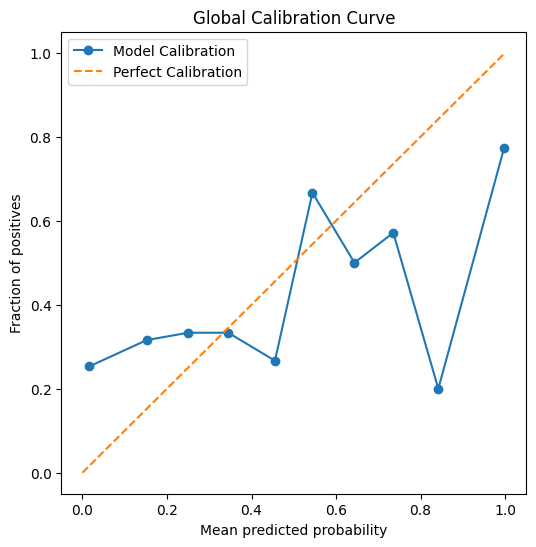

Global ECE: 0.2148
Global MCE: 0.6571
Patient 001-LO: Cannot calculate ECE/MCE (only one class present).
Patient 005-GP: Cannot calculate ECE/MCE (only one class present).
Patient 006-TR: Cannot calculate ECE/MCE (only one class present).
Patient 010-RA: Cannot calculate ECE/MCE (only one class present).
Patient 011-CB: Cannot calculate ECE/MCE (only one class present).
Patient 013-MS: Cannot calculate ECE/MCE (only one class present).
Patient 018-OS: Cannot calculate ECE/MCE (only one class present).
Patient 020-MM: Cannot calculate ECE/MCE (only one class present).
Patient 025-PS: Cannot calculate ECE/MCE (only one class present).
Patient 033-JF: Cannot calculate ECE/MCE (only one class present).
Patient 037-MA: Cannot calculate ECE/MCE (only one class present).
Patient 039-EB: Cannot calculate ECE/MCE (only one class present).
Patient 040-KR: Cannot calculate ECE/MCE (only one class present).
Patient 058-ZS: Cannot calculate ECE/MCE (only one class present).
Patient 064-SC: Cannot c

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Load dataset

dataframe = pd.read_csv(path)
dataframe = dataframe[dataframe['walking_speed'] == 'Fast']
dataframe.dropna(subset=['QoR_class'], inplace=True)



# Graph structure
# Graph structure
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [(a, b) for a, b in zip(joints[:-1], joints[1:])] 



joint_to_idx = {j: i for i, j in enumerate(joints)}
edge_index = torch.tensor([[joint_to_idx[a], joint_to_idx[b]] for a, b in edges] + 
                          [[joint_to_idx[b], joint_to_idx[a]] for a, b in edges], dtype=torch.long).t()

# Dataset
class WindowedSkeletonDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=30, stride=15):
        self.samples = []
        grouped = df.groupby(['patient_id', 'trial'])
        for (pid, trial), group in grouped:
            group = group.sort_values('t_uniform')
            if len(group) < window_size:
                continue
            for i in range(0, len(group) - window_size + 1, stride):
                window = group.iloc[i:i+window_size]
                x_seq, aux_seq = [], []
                for _, row in window.iterrows():
                    node_features = [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['t_uniform']] for j in joints]
                    x_seq.append(torch.tensor(node_features, dtype=torch.float))
                    aux_seq.append(torch.tensor([row['left_foot_swing'], row['right_foot_swing'], row['pelvis_pos']], dtype=torch.float))
                label = torch.tensor(window['QoR_class'].mode().values[0], dtype=torch.float)
                self.samples.append((torch.stack(x_seq), torch.stack(aux_seq), label, pid))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# Split
unique_ids = dataframe['patient_id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.3, random_state=42)
train_df = dataframe[dataframe['patient_id'].isin(train_ids)]
test_df = dataframe[dataframe['patient_id'].isin(test_ids)]

wind_size, stride_size, b_size = 120, 10, 16
train_dataset = WindowedSkeletonDataset(train_df, wind_size, stride_size)
test_dataset = WindowedSkeletonDataset(test_df, wind_size, stride_size)
train_loader = DataLoader(train_dataset, batch_size=b_size)
test_loader = DataLoader(test_dataset, batch_size=b_size)

# Model
class WindowedSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.gcn = GCNConv(in_channels, hidden_channels)
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)
        self.aux_fc = nn.Linear(3, hidden_channels)
        self.classifier = nn.Linear(2 * hidden_channels, 1)

    def forward(self, x_seq, aux_seq):
        B, T, N, feat_dim = x_seq.shape
        x_seq = x_seq.view(B * T * N, feat_dim)
        full_edge_index = torch.cat([edge_index + b * N for b in range(B * T)], dim=1).to(x_seq.device)
        x = F.relu(self.gcn(x_seq, full_edge_index))
        x = x.view(B, T, N, -1).mean(2)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        aux = F.relu(self.aux_fc(aux_seq.mean(1)))
        return self.classifier(torch.cat([x, aux], dim=-1)).squeeze()

# Training with Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WindowedSTGCN(4, 128).to(device)
criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(1, 100):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x_seq, aux_seq, y, _ in train_dataset:
        x_seq, aux_seq, y = x_seq.unsqueeze(0).to(device), aux_seq.unsqueeze(0).to(device), y.unsqueeze(0).to(device)
        optimizer.zero_grad()
        out = model(x_seq, aux_seq)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((torch.sigmoid(out) >= 0.5).float() == y).sum().item()
        total += 1
    print(f"Epoch {epoch:03d} | Loss: {total_loss / total:.4f} | Accuracy: {correct / total:.4f}")

# Evaluation - Per patient + Calibration Curve
def calculate_ece(probs, labels, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(probs, bins) - 1
    ece = 0.0
    for i in range(n_bins):
        bin_mask = bin_indices == i
        if bin_mask.sum() == 0:
            continue
        bin_acc = labels[bin_mask].mean()
        bin_conf = probs[bin_mask].mean()
        ece += np.abs(bin_acc - bin_conf) * bin_mask.sum() / len(probs)
    return ece

def calculate_mce(probs, labels, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(probs, bins) - 1
    mce = 0.0
    for i in range(n_bins):
        bin_mask = bin_indices == i
        if bin_mask.sum() == 0:
            continue
        bin_acc = labels[bin_mask].mean()
        bin_conf = probs[bin_mask].mean()
        mce = max(mce, np.abs(bin_acc - bin_conf))
    return mce

model.eval()
patient_results = defaultdict(list)
all_probs, all_labels = [], []

with torch.no_grad():
    for x_seq, aux_seq, y, pid in test_dataset:
        x_seq, aux_seq = x_seq.unsqueeze(0).to(device), aux_seq.unsqueeze(0).to(device)
        output = model(x_seq, aux_seq)
        prob = torch.sigmoid(output).cpu().item()
        pred_label = int(prob >= 0.5)
        true_label = int(y.item())
        patient_results[pid].append({'pred': pred_label, 'true': true_label, 'prob': prob})
        all_probs.append(prob)
        all_labels.append(true_label)

# Global Calibration
prob_true, prob_pred = calibration_curve(all_labels, all_probs, n_bins=10)
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Global Calibration Curve')
plt.legend()
plt.show()

print(f"Global ECE: {calculate_ece(np.array(all_probs), np.array(all_labels)):.4f}")
print(f"Global MCE: {calculate_mce(np.array(all_probs), np.array(all_labels)):.4f}")

# Per-patient calibration report
for pid, records in patient_results.items():
    p_probs = np.array([r['prob'] for r in records])
    p_trues = np.array([r['true'] for r in records])
    if len(np.unique(p_trues)) == 1:
        print(f"Patient {pid}: Cannot calculate ECE/MCE (only one class present).")
    else:
        ece = calculate_ece(p_probs, p_trues)
        mce = calculate_mce(p_probs, p_trues)
        print(f"Patient {pid} | ECE: {ece:.4f} | MCE: {mce:.4f}")



In [9]:
# Evaluation - Patient-wise report
model.eval()
patient_results = defaultdict(list)

with torch.no_grad():
    for x_seq, aux_seq, y, pid in test_dataset:
        x_seq, aux_seq = x_seq.unsqueeze(0).to(device), aux_seq.unsqueeze(0).to(device)
        output = model(x_seq, aux_seq)
        prob = torch.sigmoid(output).item()
        pred_label = int(prob >= 0.5)
        true_label = int(y.item())

        patient_results[pid].append({
            'pred': pred_label,
            'true': true_label,
            'prob': prob
        })

# Summarize per patient
summary = []
for pid, records in patient_results.items():
    preds = [r['pred'] for r in records]
    trues = [r['true'] for r in records]
    probs = [r['prob'] for r in records]

    correct_count = sum(p == t for p, t in zip(preds, trues))
    total = len(records)
    valid_percentage = 100 * correct_count / total
    invalid_percentage = 100 - valid_percentage

    summary.append({
        'PatientID': pid,
        'Predicted_QoR_class': max(set(preds), key=preds.count),
        'Actual_QoR_class': max(set(trues), key=trues.count),
        'valid_percentage': round(valid_percentage, 2),
        'invalid_percentage': round(invalid_percentage, 2),
        'average_model_output': round(sum(probs) / len(probs), 6)
    })

# Display
report_df = pd.DataFrame(summary).sort_values(by='PatientID').reset_index(drop=True)
print(report_df)


   PatientID  Predicted_QoR_class  Actual_QoR_class  valid_percentage  \
0     001-LO                    0                 1             42.86   
1     005-GP                    0                 0             66.67   
2     006-TR                    0                 1              0.00   
3     010-RA                    0                 0             94.12   
4     011-CB                    0                 0             87.50   
5     013-MS                    0                 1             15.79   
6     018-OS                    0                 0             62.50   
7     020-MM                    0                 0             83.33   
8     025-PS                    0                 1             28.57   
9     033-JF                    0                 1             33.33   
10    037-MA                    0                 0            100.00   
11    039-EB                    0                 0             94.12   
12    040-KR                    0                 1